In [ ]:
from collections import defaultdict
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sb
import pickle as pkl
from braindecode.datasets import BaseConcatDataset, create_from_X_y
from shutil import copyfile
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment
from alignment import np_compute_transform_mat, np_euclidean_alignment, np_compute_target_transform_mats, np_label_alignment
from util import np_standardize

In [ ]:
# data_dir = "/content/drive/MyDrive/DataVIN/Official"
# als_data_dir = "/content/drive/MyDrive/VIN_ALS"
data_dir = "../data/vin/Official"
als_data_dir = "../data/vin/Official"

In [74]:
%%time
# fmt: off
# subjects = [
#     'K300', 'K309', 'K310', 'K311', 'K312', 
#     'K313', 'K314', 'K315', 'K316', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004',
    'K005', 'K006', 'K007', 'K008', 'K009',
    'K010', 'K011', 'K012', 'K013', 'K014',
    'K015', 'K016', 'K017', 'K018', 'K019',
    'K020', 'K021', 'K022', 'K023', 'K024',
    'K025', 'K026', 'K027', 'K028', 'K299',
    'K300', 'K301', 'K302', 'K303', 'K304',
    'K305', 'K306', 'K307', 'K308', 'K309',
    'K310', 'K311', 'K312', 'K313', 'K314',
    'K315', 'K316', 'K317', 'K319',
    'K320', 'K321', 'K322', 'K323', 'K324',
    'K325', 'K326', 'K327', 'K328', 'K329',
    'K330', 'K331', 'K332', 'K333', 'K334',
    'K335', 'K336', 'K337', 'K338', 'K339',
    'K340', 'K342', 'K343', 'K344', 'K350',
    'K351', 'K352', 'K353', 'K354', 'K355',
    'K356', 'K357', 'K358', 'K359', 'K360',
    'K361', 'K362', 'K363', 'K364', 'K365',
    'K366', 'K367', 'K368', 'K369', 'K370',
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    "Thinking and Acting",
    "Resting",
    # "Typing",
]

# channels = [
#     "Fp1", "Fp2",
#     "F7", "F3", "Fz", "F4", "F8",
#     "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
#     # "FC5", "FC1", "FC2", "FC6",
#     "T7", "C3", "Cz", "C4", "T8",
#     "CP5", "CP1", "CP2", "CP6",
#     "P7", "P3", "Pz", "P4", "P8",
#     "PO9", "O1", "Oz", "O2", "PO10",
#     # "O1", "Oz", "O2",
# ]
channels = [
    # "F3", "Fz", "F4",
    "FC5", "FC1", "FC2", "FC6",
    "C3", "C4",
    "CP5", "CP1", "CP2", "CP6",
    # "P3", "Pz", "P4",
]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "há miệng_Thinking": "há miệng",
    # "há miệng_Thinking": "mi",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 3  # @param
window_duration = 2
window_stride_duration = 0.5

fmin = 8.0  # @param
fmax = None  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

# als_ds = load_data(
#     als_data_dir,  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = BaseConcatDataset([ds, als_ds])

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 10 channels


subject:  12%|█▏        | 13/109 [00:00<00:01, 92.33it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  27%|██▋       | 29/109 [00:00<00:02, 34.20it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.i

loaded 96 subjects - 34836 epochs
CPU times: user 1min 10s, sys: 6.52 s, total: 1min 17s
Wall time: 1min 20s


,subject,scenario,event,label,trial,split,epochs
0,K001,nâng tay trái,Thinking,nâng tay trái,0,train,9
1,K001,nâng tay trái,Resting,rest,0,train,10
2,K001,nâng tay trái,Thinking and Acting,nâng tay trái,0,train,22
3,K001,nâng tay trái,Resting,rest,1,train,5
4,K001,nâng tay trái,Thinking,nâng tay trái,1,train,10
...,...,...,...,...,...,...,...
3703,K375,nâng chân phải,Resting,rest,3,train,5
3704,K375,nâng chân phải,Thinking,nâng chân phải,2,train,11
3705,K375,nâng chân phải,Resting,rest,4,train,6
3706,K375,nâng chân phải,Thinking and Acting,nâng chân phải,2,train,9


In [4]:
import numpy as np
from scipy import linalg, stats, signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
# import yasa
from mne_features.feature_extraction import FeatureExtractor
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from pyriemann.estimation import Covariances
# from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
import pickle as pkl
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict

/home/administrator/.local/lib/python3.8/site-packages/mne_features/mock_numba.py:12: UserWarning: Numba needs NumPy 1.20 or less. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


In [5]:
validate_subjects = {
    'K300', 'K309', 'K310', 'K311', 'K312', 
    # 'K313', 'K314', 'K315', 'K316', 'K319', 
    # 'K320', 'K321', 'K322', 'K323', 'K324', 
    # 'K325', 'K326', 'K327', 'K328', 'K329', 
    # 'K330', 'K331', 'K332', 'K333', 'K334', 
    # 'K335', 'K336', 'K337', 'K338', 'K339', 
    # 'K340', 'K342', 'K343', 'K344', 'K350', 
    # 'K351', 'K352', 'K353', 'K354', 'K355', 
    # 'K356', 'K357', 'K358', 'K359', 'K360', 
    # 'K361', 'K362', 'K363', 'K364', 'K365', 
    # 'K366', 'K367', 'K368', 'K369', 'K370', 
    # 'K371', 'K372', 'K373', 'K374', 'K375',
}

In [75]:
exp_ds = deepcopy(ds)
euclidean_alignment(exp_ds, target_subject=None, labeled_trials=None)

# exp_ds = list()
# for i, r in ds_info[ds_info["subject"] == "K309"].iterrows():
#     exp_ds.append(ds.datasets[i])
    
# exp_ds = BaseConcatDataset(exp_ds)
# len(exp_ds)

subject: 100%|██████████| 96/96 [00:03<00:00, 28.45it/s]


In [76]:
Xtrain = list()
Ytrain = list()
Xtest = list()
Ytest = list()
for _ds in exp_ds.datasets:
    if _ds.description["subject"] in validate_subjects:
        Xtest.append(_ds.windows.get_data())
        Ytest.extend(_ds.y)
    else:
        Xtrain.append(_ds.windows.get_data())
        Ytrain.extend(_ds.y)
    
Xtrain = np.concatenate(Xtrain, axis=0)
Ytrain = np.array(Ytrain, dtype=int)
Xtest = np.concatenate(Xtest, axis=0)
Ytest = np.array(Ytest, dtype=int)

Xtrain.shape, Xtest.shape

((32404, 10, 256), (2432, 10, 256))

In [77]:
np.bincount(Ytrain), np.bincount(Ytest)

(array([13263,  3830,  5512,  3880,  5919]),
 array([1160,  325,  304,  313,  330]))

<AxesSubplot:>

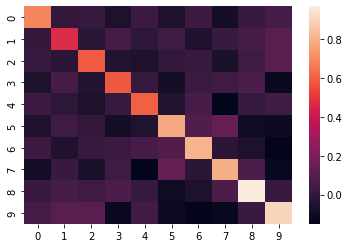

In [78]:
sb.heatmap(np.cov(Xtrain[0], rowvar=True))

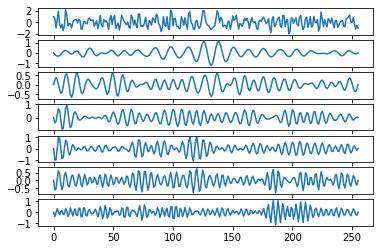

In [79]:
fig, axes = plt.subplots(nrows=7, ncols=1)

axes[0].plot(range(256), Xtrain[0, 0])
for i, (low, high) in enumerate([(8,12), (12,16), (16,20), (20,24), (24,28), (28,32)]):
    axes[i + 1].plot(range(256), mne.filter.filter_data(Xtrain[0, 0], sfreq=128.0, l_freq=low, h_freq=high, verbose=False))

In [46]:
csp = mne.decoding.CSP(
    n_components=32,
    # reg="ledoit_wolf",
    log=None,
    norm_trace=False,
    transform_into="csp_space",
)

Xtrain = csp.fit_transform(Xtrain, Ytrain)
Xtest = csp.transform(Xtest)

In [47]:
Xtrain.shape, Xtest.shape
# Xtrain.shape

((32404, 32, 256), (2432, 32, 256))

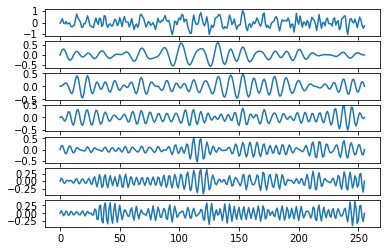

In [48]:
fig, axes = plt.subplots(nrows=7, ncols=1)

axes[0].plot(range(256), Xtrain[0, 0])
for i, (low, high) in enumerate([(8,12), (12,16), (16,20), (20,24), (24,28), (28,32)]):
    axes[i + 1].plot(range(256), mne.filter.filter_data(Xtrain[0, 0], sfreq=128.0, l_freq=low, h_freq=high, verbose=False))

<AxesSubplot:>

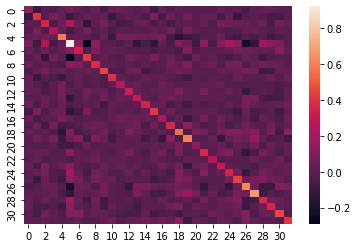

In [49]:
sb.heatmap(np.cov(Xtrain[0], rowvar=True))

In [607]:
plt.rcParams["figure.figsize"] = (10, 8)

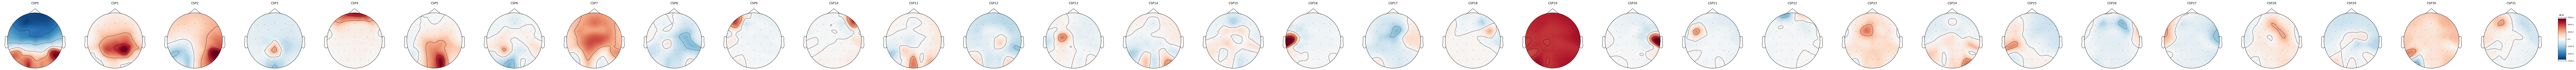

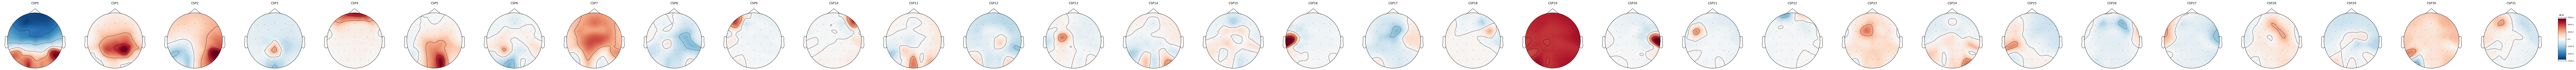

In [50]:
csp.plot_patterns(exp_ds.datasets[0].windows.info, size=3)

In [25]:
Ytrain[:10]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 0])

In [29]:
epochs = mne.EpochsArray(Xtrain[np.where(Ytrain == 1)[0]], info=exp_ds.datasets[0].windows.info)

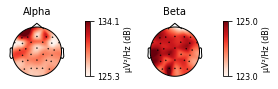

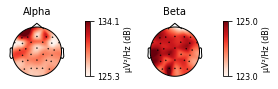

In [31]:
epochs.plot_psd_topomap(bands=[(8, 12, "Alpha"), (12, 32, "Beta")])

In [80]:
bands = [(8,12), (12,16), (16,20), (20,24), (24,28), (28, 32)]
params = dict({
    'pow_freq_bands__log': True,
    'pow_freq_bands__normalize': False,
    'pow_freq_bands__freq_bands': bands,
})

fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'],params=params,n_jobs=-1)
Xtrain_bp = fe.fit_transform(Xtrain)
Xtest_bp = fe.transform(Xtest)

Xtrain_bp.shape, Xtest_bp.shape

((32404, 60), (2432, 60))

In [84]:
%%time
clf = SVC(
    C=1.0,
    kernel="rbf",
    tol=1e-7,
    max_iter=100000,
    class_weight="balanced",
    random_state=42,
)

clf.fit(Xtrain_bp, Ytrain)

CPU times: user 3min 4s, sys: 1.25 ms, total: 3min 4s
Wall time: 3min 4s


SVC(class_weight='balanced', max_iter=100000, random_state=42, tol=1e-07)

In [85]:
Ypred = clf.predict(Xtest_bp)

In [86]:
metrics.balanced_accuracy_score(Ytest, Ypred)

0.27363392428337086

In [87]:
metrics.confusion_matrix(Ytest, Ypred)

array([[666,  46, 141,  86, 221],
       [105,  64,  47,  41,  68],
       [115,  27,  81,  25,  56],
       [106,  24,  60,  39,  84],
       [119,  28,  43,  72,  68]])

In [614]:
subject_ds = list()
for i, r in ds_info[ds_info["subject"] == "K300"].iterrows():
    subject_ds.append(ds.datasets[i])
    
subject_ds = BaseConcatDataset(subject_ds)

In [615]:
X = list()
Y = list()
for _ds in subject_ds.datasets:
    X.append(_ds.windows.get_data())
    Y.extend(_ds.y)
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

X.shape

(204, 32, 256)

In [616]:
C = np.stack([np.cov(x, rowvar=True) for x in X])
C.shape

(204, 32, 32)

In [617]:
R = C.mean(axis=0)

<AxesSubplot:>

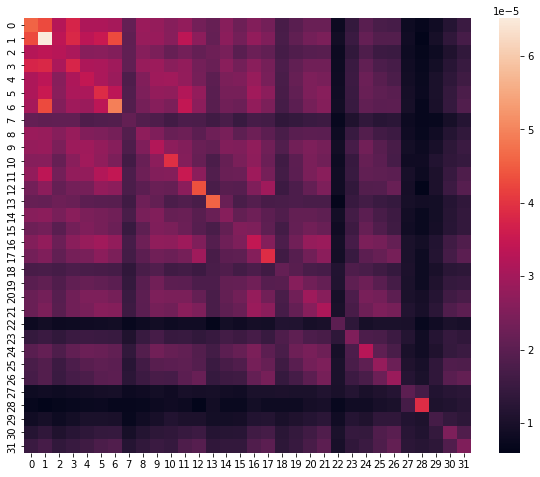

In [618]:
sb.heatmap(R)

In [589]:
R0 = linalg.inv(linalg.sqrtm(R))

In [590]:
Z0 = R0[None] @ X

<AxesSubplot:>

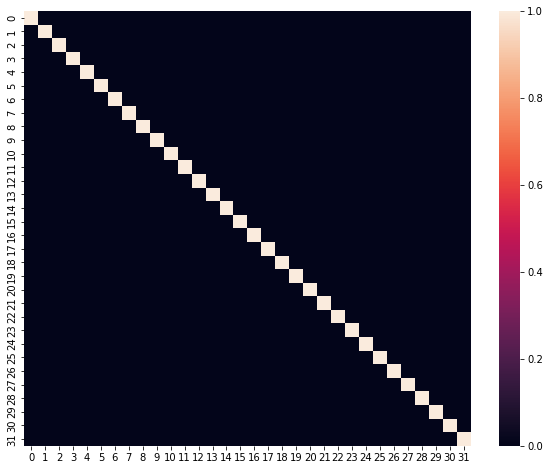

In [591]:
sb.heatmap(np.stack([np.cov(z, rowvar=True) for z in Z0]).mean(axis=0))

In [592]:
evals, evecs = linalg.eigh(R)

In [575]:
Z1 = np.diag(evals ** -0.5)[None] @ evecs[None] @ X

<AxesSubplot:>

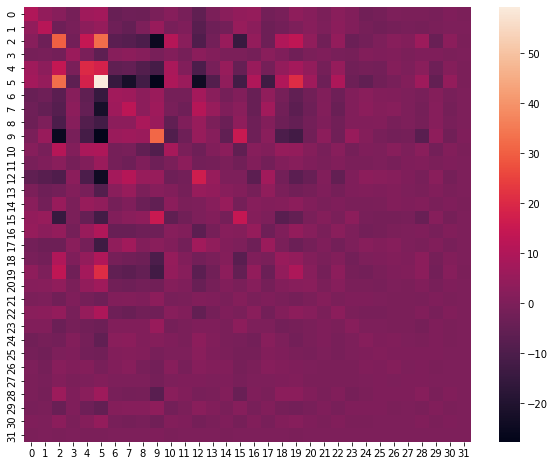

In [583]:
M1 = np.stack([np.cov(z, rowvar=True) for z in Z1]).mean(axis=0)
sb.heatmap(M1)

In [593]:
Z2 = np.diag(evals ** -0.5)[None] @ evecs[None] @ X

<AxesSubplot:>

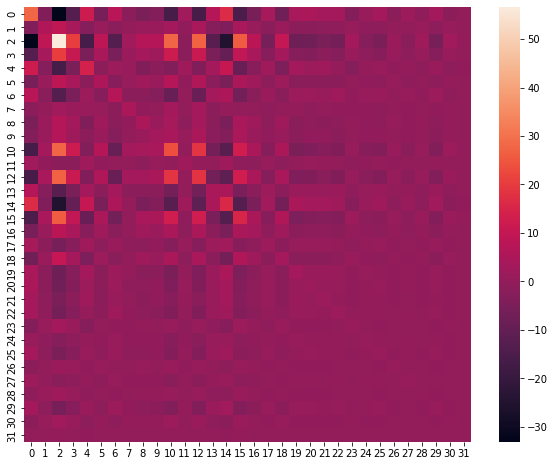

In [594]:
M2 = np.stack([np.cov(z, rowvar=True) for z in Z2]).mean(axis=0)
sb.heatmap(M2)

<AxesSubplot:>

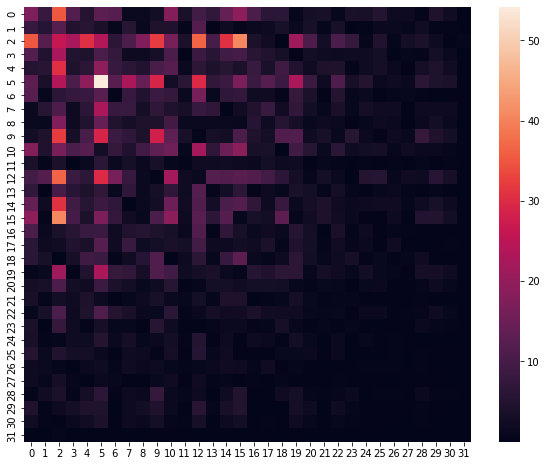

In [597]:
sb.heatmap(np.abs(M2 - M1))